**Import files**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm
import csv
import cv2
import imageio

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps

In [2]:
image_filenames = [i for i in os.listdir('UTKFace/')] 

# Data Visualisation

**Gender-Male**

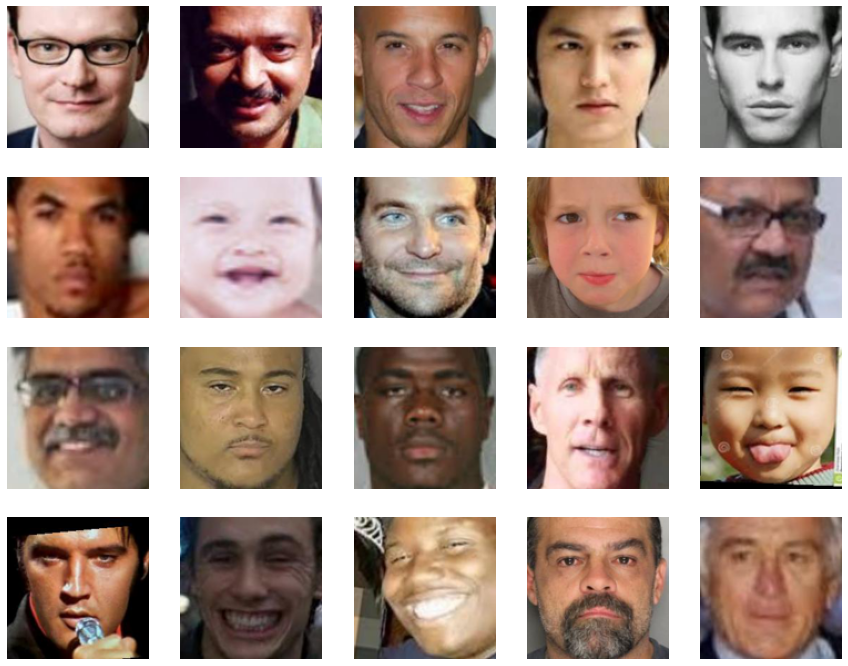

In [3]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    #Extracting gender from the image name
    gender=str('UTKFace/'+image_filenames[rand].split('_')[1])[-1]
    if ii>=maxtoshow:
        break
    if gender=='0' :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(Image.open('UTKFace/'+image_filenames[rand]).resize((128,128)))
        ii = ii + 1

**Gender-Female**

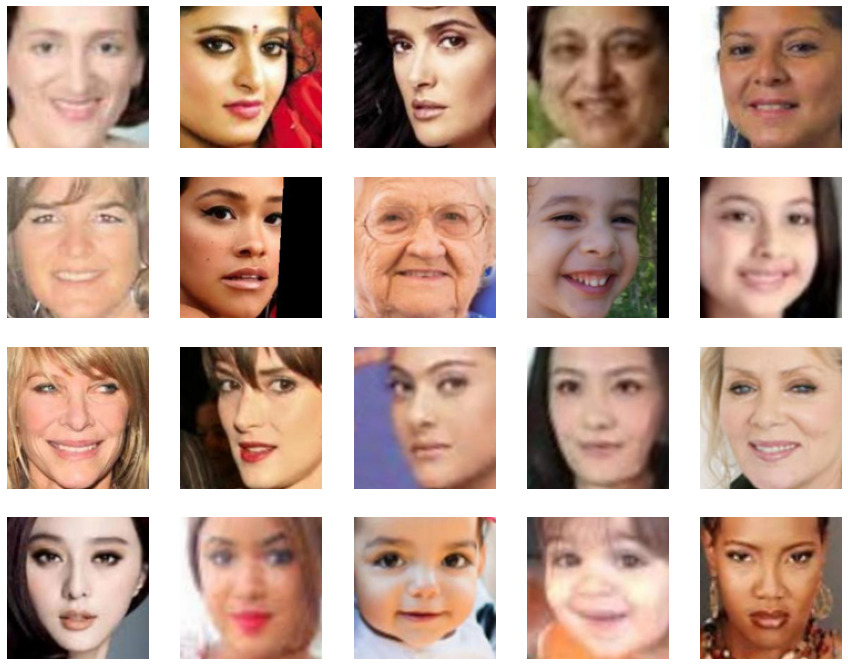

In [4]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    #Extracting gender from the image name
    gender=str('UTKFace/'+image_filenames[rand].split('_')[1])[-1]
    if ii>=maxtoshow:
        break
    if gender=='1' :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(Image.open('UTKFace/'+image_filenames[rand]).resize((128,128)))
        ii = ii + 1

# PreProcessing

In [5]:
genders=[]
# Iterate throuigh the filenames and for each one load the image, resize and normalise
count = len(image_filenames)
images=[]
for i, image_file in enumerate(image_filenames):
        gender=image_file.split('_')[1]
        #image = imageio.imread('UTKFace/'+image_file)
        image= cv2.imread('UTKFace/'+image_file,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200,200), interpolation=cv2.INTER_CUBIC)        
        if i%10000==0:
            print('Processed {} of {} images'.format(i + 1, count))
        genders.append(int(gender))
        images.append(image)

Processed 1 of 23708 images
Processed 10001 of 23708 images
Processed 20001 of 23708 images


Checking images after preprocessing

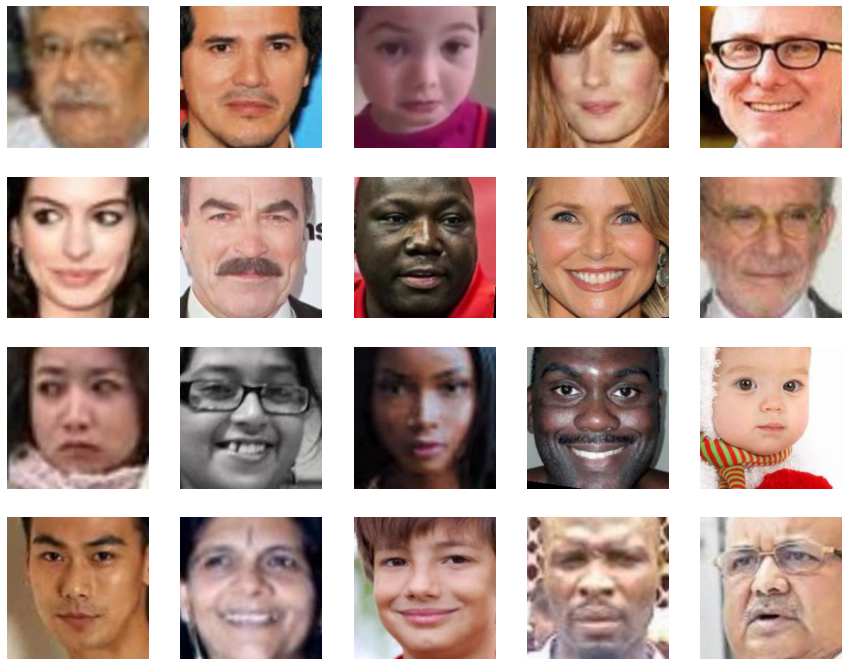

In [6]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    if ii>=maxtoshow:
        break
    else:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images[rand])
        ii = ii + 1

Add the data to DataFrame

In [7]:
#Convert to series
images_list = pd.Series(list(images),name='Images')
genders_list = pd.Series(list(genders),name='Gender')

df = pd.concat([images_list, genders_list],axis=1)
df.head()

Images  Gender
0  [[[215, 206, 201], [213, 204, 199], [212, 203,...       0
1  [[[118, 122, 133], [120, 124, 135], [122, 126,...       0
2  [[[219, 223, 226], [232, 235, 240], [232, 237,...       1
3  [[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...       1
4  [[[65, 69, 80], [66, 70, 81], [67, 71, 82], [6...       1

**Distribution of data**

C:\Users\MLPUser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


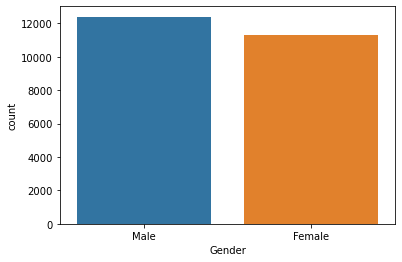

In [8]:
sns.countplot(df['Gender'])
labels = ["Male", "Female"]
plt.xticks(range(2),labels)
plt.show()

In [9]:
X = []
for i in range(len(df)):
    img = np.asarray(df['Images'].iloc[i])
    X.append(img)
X = np.array(X)

Train test split

In [10]:
y_gender = df['Gender']
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2)

In [11]:
#Normalising the images
x_train_gender = x_train_gender/255
x_test_gender = x_test_gender/255

# Model Building

**Trial 1 with hyperparameters**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [61]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), input_shape=(200,200,3)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 5)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (2, 2)))
        model.add(Activation('relu'))

    model.add(Flatten()) 
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(optimizer='adam',loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [62]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='gender',
    project_name='gender prediction')

In [63]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [64]:
tuner.search(x_train_gender, y_train_gender,
             epochs=5,
             validation_data=(x_test_gender, y_test_gender))

Trial 1 Complete [02h 08m 07s]
val_accuracy: 0.8738928437232971

Best val_accuracy So Far: 0.8738928437232971
Total elapsed time: 02h 08m 07s
INFO:tensorflow:Oracle triggered exit


In [42]:
x_train_gender.shape[1:]

(200, 200, 3)

In [65]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 96,
 'n_layers': 4,
 'conv_0_units': 64,
 'conv_1_units': 32,
 'conv_2_units': 32,
 'conv_3_units': 32}

In [67]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 96)      2688      
_________________________________________________________________
activation (Activation)      (None, 198, 198, 96)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 64)        24640     
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 32)        8224      
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 32)        0

In [69]:
tuner.results_summary()

Results summary
Results in gender\denfer prediction
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 96
n_layers: 4
conv_0_units: 64
conv_1_units: 32
conv_2_units: 32
conv_3_units: 32
Score: 0.8738928437232971


In [71]:
y_pred_gender = tuner.get_best_models()[0].predict(x_test_gender)

In [73]:
y_pred_gender =np.round(y_pred_gender)

0.8728812621070737


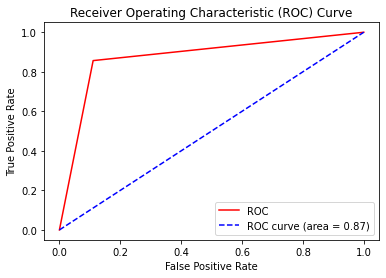

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_gender, y_pred_gender)
auc = roc_auc_score(y_test_gender, y_pred_gender)
print(auc)


plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import classification_report
#0 -Male 1-Female
print(classification_report(y_test_gender, y_pred_gender,target_names=['Male','Female']))

              precision    recall  f1-score   support

        Male       0.88      0.89      0.88      2518
      Female       0.87      0.86      0.86      2224

    accuracy                           0.87      4742
   macro avg       0.87      0.87      0.87      4742
weighted avg       0.87      0.87      0.87      4742



C:\Users\Sushmita\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


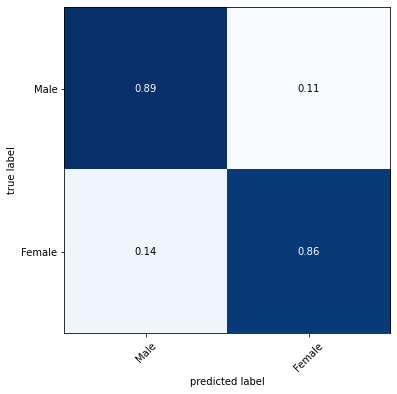

In [76]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_gender, y_pred_gender)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,show_normed=True,
                                show_absolute=False,
                                class_names=['Male','Female'],
                                figsize=(6, 6))
fig.show()

In [77]:
TN, FP,FN, TP = confusion_matrix(y_test_gender, y_pred_gender).ravel()

In [79]:
(TN, FP,FN, TP)

(2239, 279, 319, 1905)

In [78]:
accuracy = (TP+TN)/(TP+FP+FN+TN)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print('Accuracy %=',np.round(accuracy,2)*100)
print('True Positive Rate %=',np.round(TPR,2)*100)
print('False Positive Rate %=',np.round(FPR,2)*100)

Accuracy %= 87.0
True Positive Rate %= 86.0
False Positive Rate %= 11.0


**Trial 2 with hyperparameters**

In [12]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), input_shape=x_train_gender.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 2, 4)): 
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (2, 2)))
        model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(Adam(learning_rate=hp_learning_rate),loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [14]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='gender',
    project_name='gender prediction')

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [16]:
tuner.search(x_train_gender, y_train_gender,
             epochs=4,
             validation_data=(x_test_gender, y_test_gender))

Trial 3 Complete [01h 14m 41s]
val_accuracy: 0.8882328271865845

Best val_accuracy So Far: 0.8882328271865845
Total elapsed time: 03h 27m 41s
INFO:tensorflow:Oracle triggered exit


In [20]:
best_model=tuner.get_best_models()[0]

Best model

In [21]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        4128      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 256)       33024     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 256)       0

Best hyperparameters

In [18]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 32,
 'n_layers': 3,
 'conv_0_units': 32,
 'conv_1_units': 256,
 'learning_rate': 0.0001,
 'conv_2_units': 192}

In [19]:
tuner.results_summary()

Results summary
Results in gender\gender prediction
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 32
n_layers: 3
conv_0_units: 32
conv_1_units: 256
learning_rate: 0.0001
conv_2_units: 192
Score: 0.8882328271865845
Trial summary
Hyperparameters:
input_units: 32
n_layers: 3
conv_0_units: 256
conv_1_units: 64
learning_rate: 0.001
conv_2_units: 32
Score: 0.8753690719604492
Trial summary
Hyperparameters:
input_units: 96
n_layers: 2
conv_0_units: 160
conv_1_units: 224
learning_rate: 0.001
conv_2_units: 192
Score: 0.8593420386314392


In [19]:
best_model = Sequential()
best_model.add(Conv2D(32, (3,3), input_shape=(200,200, 3)))
best_model.add(Activation('relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Conv2D(32, (2,2)))
best_model.add(Activation('relu'))

best_model.add(Conv2D(256, (2,2)))
best_model.add(Activation('relu'))

best_model.add(Conv2D(192, (2,2)))
best_model.add(Activation('relu'))

best_model.add(Flatten())
best_model.add(Dense(64))
best_model.add(Activation('relu'))
best_model.add(Dropout(0.5))
best_model.add(Dense(1))
best_model.add(Activation("sigmoid"))

best_model.compile(Adam(learning_rate=0.0001),loss='binary_crossentropy',
             metrics=['accuracy'])
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        4128      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 256)       33024     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 256)       0

In [22]:
batch_size = 128
epochs = 30

best_weights_filepath = './GenderModel.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",save_best_only=True, save_weights_only=False,mode='max')

historygender = best_model.fit(x_train_gender, y_train_gender,batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_gender, y_test_gender),
          shuffle=True,
          callbacks=[mcp])

#reload best weights
best_model.load_weights(best_weights_filepath)

Epoch 1/30
149/149 [==============================] - 1064s 7s/step - loss: 0.6351 - accuracy: 0.6621 - val_loss: 0.4187 - val_accuracy: 0.8260
Epoch 2/30
149/149 [==============================] - 977s 7s/step - loss: 0.4662 - accuracy: 0.7839 - val_loss: 0.3719 - val_accuracy: 0.8600
Epoch 3/30
149/149 [==============================] - 973s 7s/step - loss: 0.4225 - accuracy: 0.8150 - val_loss: 0.3237 - val_accuracy: 0.8747
Epoch 4/30
149/149 [==============================] - 967s 6s/step - loss: 0.4020 - accuracy: 0.8326 - val_loss: 0.3122 - val_accuracy: 0.8743
Epoch 5/30
149/149 [==============================] - 963s 6s/step - loss: 0.3842 - accuracy: 0.8428 - val_loss: 0.2903 - val_accuracy: 0.8754
Epoch 6/30
149/149 [==============================] - 965s 6s/step - loss: 0.3731 - accuracy: 0.8537 - val_loss: 0.2834 - val_accuracy: 0.8846
Epoch 7/30
149/149 [==============================] - 965s 6s/step - loss: 0.3626 - accuracy: 0.8551 - val_loss: 0.2820 - val_accuracy: 0.887

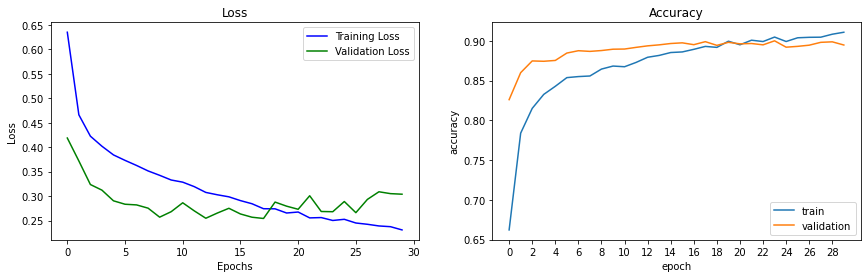

In [23]:
plt.subplots_adjust(left=None, bottom=None, right = 2, top=None, wspace=None, hspace=None)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
loss = historygender.history['loss']
val_loss = historygender.history['val_loss']
epochs=30
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(historygender.history['accuracy'])
plt.plot(historygender.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,epochs)[0::2])
plt.legend(['train', 'validation'], loc='lower right')

In [24]:
y_pred_gender = best_model.predict(x_test_gender)

In [25]:
y_pred_gender =np.round(y_pred_gender)

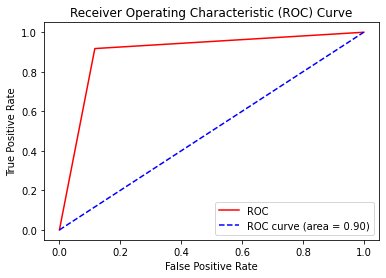

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_gender, y_pred_gender)
auc = roc_auc_score(y_test_gender, y_pred_gender)

plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import classification_report
#0 -Male 1-Female
print(classification_report(y_test_gender, y_pred_gender,target_names=['Male','Female']))

              precision    recall  f1-score   support

        Male       0.92      0.88      0.90      2440
      Female       0.88      0.92      0.90      2302

    accuracy                           0.90      4742
   macro avg       0.90      0.90      0.90      4742
weighted avg       0.90      0.90      0.90      4742



<ipython-input-28-56e71942abb3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


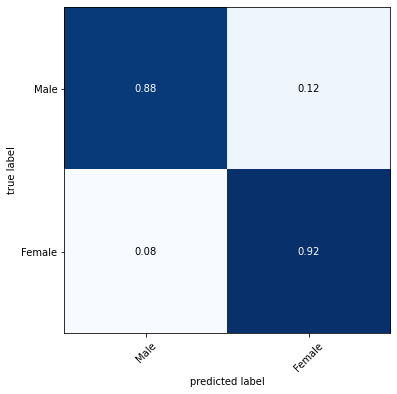

In [28]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_gender, y_pred_gender)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,show_normed=True,
                                show_absolute=False,
                                class_names=['Male','Female'],
                                figsize=(6, 6))
fig.show()

In [29]:
TN, FP,FN, TP = confusion_matrix(y_test_gender, y_pred_gender).ravel()

In [30]:
(TN, FP,FN, TP)

(2156, 284, 190, 2112)

In [31]:
accuracy = (TP+TN)/(TP+FP+FN+TN)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print('Accuracy %=',np.round(accuracy,2)*100)
print('True Positive Rate %=',np.round(TPR,2)*100)
print('False Positive Rate %=',np.round(FPR,2)*100)

Accuracy %= 90.0
True Positive Rate %= 92.0
False Positive Rate %= 12.0


True positive rate ,accuracy and AUC improved compared to Trial1

In [32]:
y_pred=np.int64(y_pred_gender.flatten())

In [33]:

corrects=y_pred==y_test_gender
corrects

5435      True
4649      True
122       True
3725      True
8255      True
         ...  
18383     True
2600      True
3596      True
15208    False
7423      True
Name: Gender, Length: 4742, dtype: bool

**Correct Classifications**

In [34]:
y_test_gen=np.array(y_test_gender)
y_test_gen

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [35]:
gender={0:'Male',1:'Female'}

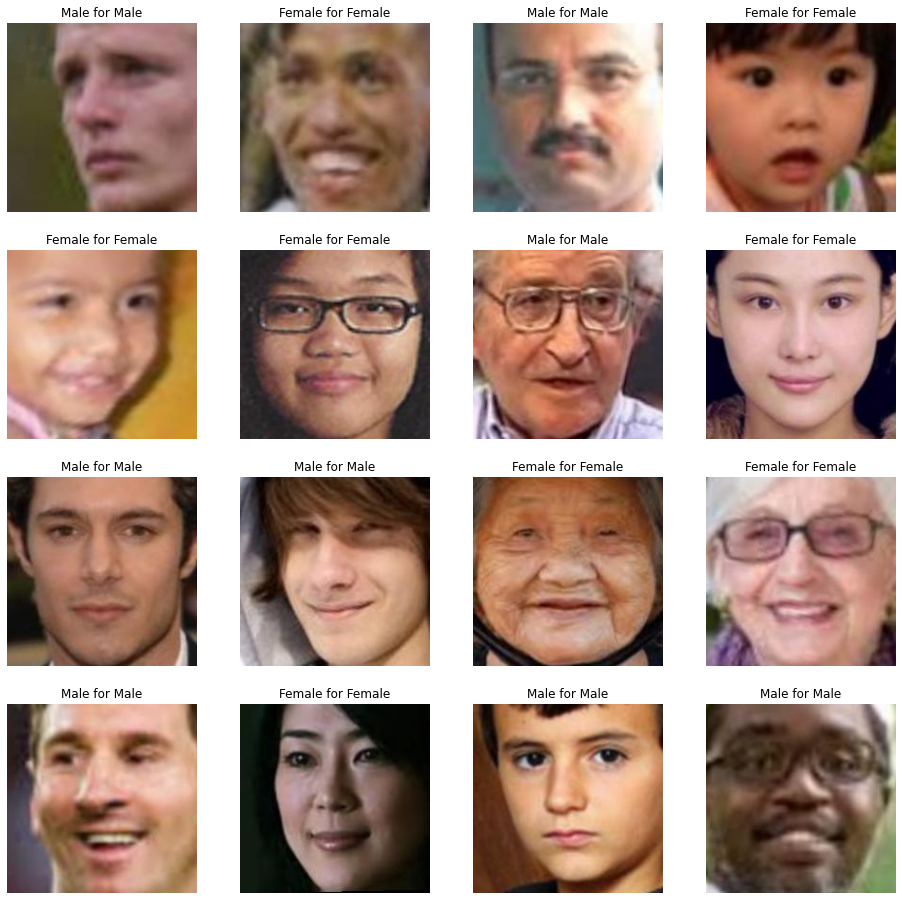

In [36]:
import PIL
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test_gender.shape[0]):
    rand =random.randint(0,x_test_gender.shape[0])
    if ii>=maxtoshow:
        break
    if y_pred[rand]==y_test_gen[rand] :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((x_test_gender[rand]) * 255).astype(np.uint8)))
        pred = 'Male' if y_test_gen[rand]==0 else 'Female'
        plt.title("{} for {}".format(gender[y_pred[rand]],pred ))
        ii = ii + 1

**Incorrect Classifications**

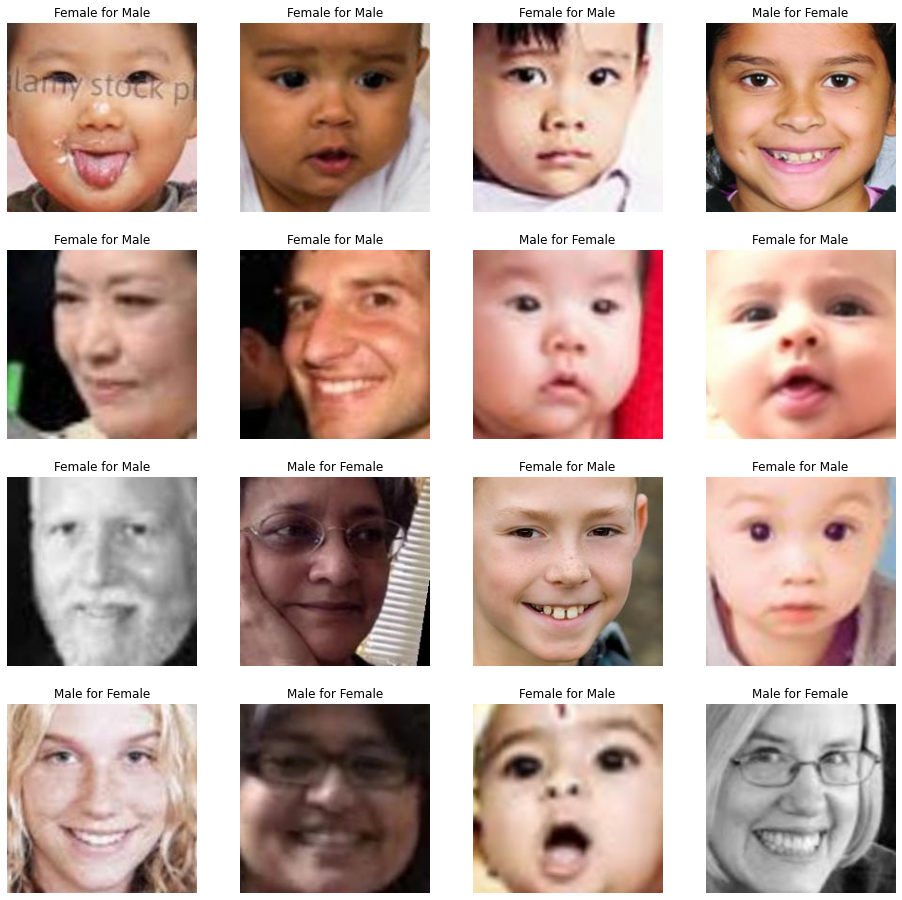

In [37]:
import PIL
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test_gender.shape[0]):
    rand =random.randint(0,x_test_gender.shape[0])
    if ii>=maxtoshow:
        break
    if y_pred[rand]!=y_test_gen[rand] :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((x_test_gender[rand]) * 255).astype(np.uint8)))
        pred = 'Male' if y_test_gen[rand]==0 else 'Female'
        plt.title("{} for {}".format(gender[y_pred[rand]],pred ))
        ii = ii + 1

It is observed that most misclassifications are among young children and babies

In [38]:
corr=[]
err=[]
for i in corrects:
    if i==True:
        corr.append(i)
    else:
        err.append(i)

In [47]:
mis=len(err)/len(y_pred)
print('Misclassification Rate %:',mis*100)

Misclassification Rate %: 9.995782370307888


In [41]:
len(err)

474